# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:14 - loss: 0.6956

  25/1875 [..............................] - ETA: 3s - loss: 0.5771   

  51/1875 [..............................] - ETA: 3s - loss: 0.4913

  80/1875 [>.............................] - ETA: 3s - loss: 0.4406

 111/1875 [>.............................] - ETA: 3s - loss: 0.4075

 141/1875 [=>............................] - ETA: 3s - loss: 0.3852

 163/1875 [=>............................] - ETA: 3s - loss: 0.3723

 188/1875 [==>...........................] - ETA: 3s - loss: 0.3600

 214/1875 [==>...........................] - ETA: 3s - loss: 0.3492

 240/1875 [==>...........................] - ETA: 3s - loss: 0.3399

 272/1875 [===>..........................] - ETA: 3s - loss: 0.3299

 303/1875 [===>..........................] - ETA: 2s - loss: 0.3214

 334/1875 [====>.........................] - ETA: 2s - loss: 0.3140

 362/1875 [====>.........................] - ETA: 2s - loss: 0.3079

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3027

 413/1875 [=====>........................] - ETA: 2s - loss: 0.2981

 436/1875 [=====>........................] - ETA: 2s - loss: 0.2941

 458/1875 [======>.......................] - ETA: 2s - loss: 0.2906

 486/1875 [======>.......................] - ETA: 2s - loss: 0.2864

 516/1875 [=======>......................] - ETA: 2s - loss: 0.2821

 542/1875 [=======>......................] - ETA: 2s - loss: 0.2787

 558/1875 [=======>......................] - ETA: 2s - loss: 0.2767

 589/1875 [========>.....................] - ETA: 2s - loss: 0.2730

 620/1875 [========>.....................] - ETA: 2s - loss: 0.2695

 650/1875 [=========>....................] - ETA: 2s - loss: 0.2663

 676/1875 [=========>....................] - ETA: 2s - loss: 0.2636

 703/1875 [==========>...................] - ETA: 2s - loss: 0.2610

 732/1875 [==========>...................] - ETA: 2s - loss: 0.2584

 756/1875 [===========>..................] - ETA: 2s - loss: 0.2563

 785/1875 [===========>..................] - ETA: 2s - loss: 0.2538

 814/1875 [============>.................] - ETA: 1s - loss: 0.2515

 842/1875 [============>.................] - ETA: 1s - loss: 0.2493

 870/1875 [============>.................] - ETA: 1s - loss: 0.2472

 901/1875 [=============>................] - ETA: 1s - loss: 0.2450

 930/1875 [=============>................] - ETA: 1s - loss: 0.2430

 955/1875 [==============>...............] - ETA: 1s - loss: 0.2414

 982/1875 [==============>...............] - ETA: 1s - loss: 0.2396

1004/1875 [===============>..............] - ETA: 1s - loss: 0.2383

1034/1875 [===============>..............] - ETA: 1s - loss: 0.2365

1065/1875 [================>.............] - ETA: 1s - loss: 0.2347

1093/1875 [================>.............] - ETA: 1s - loss: 0.2331

1123/1875 [================>.............] - ETA: 1s - loss: 0.2315

1156/1875 [=================>............] - ETA: 1s - loss: 0.2298

1189/1875 [==================>...........] - ETA: 1s - loss: 0.2281

1217/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1244/1875 [==================>...........] - ETA: 1s - loss: 0.2254

1272/1875 [===================>..........] - ETA: 1s - loss: 0.2241

1300/1875 [===================>..........] - ETA: 1s - loss: 0.2229

1326/1875 [====================>.........] - ETA: 1s - loss: 0.2217

1352/1875 [====================>.........] - ETA: 0s - loss: 0.2206

1380/1875 [=====================>........] - ETA: 0s - loss: 0.2195

1407/1875 [=====================>........] - ETA: 0s - loss: 0.2183

1433/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1459/1875 [======================>.......] - ETA: 0s - loss: 0.2163

1481/1875 [======================>.......] - ETA: 0s - loss: 0.2155

1504/1875 [=======================>......] - ETA: 0s - loss: 0.2146

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2137

1553/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1578/1875 [========================>.....] - ETA: 0s - loss: 0.2119

1604/1875 [========================>.....] - ETA: 0s - loss: 0.2110

1631/1875 [=========================>....] - ETA: 0s - loss: 0.2101

1657/1875 [=========================>....] - ETA: 0s - loss: 0.2092

1681/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1707/1875 [==========================>...] - ETA: 0s - loss: 0.2076

1732/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1755/1875 [===========================>..] - ETA: 0s - loss: 0.2061

1776/1875 [===========================>..] - ETA: 0s - loss: 0.2055

1796/1875 [===========================>..] - ETA: 0s - loss: 0.2049

1814/1875 [============================>.] - ETA: 0s - loss: 0.2043

1834/1875 [============================>.] - ETA: 0s - loss: 0.2037

1857/1875 [============================>.] - ETA: 0s - loss: 0.2031

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2025


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1101

  26/1875 [..............................] - ETA: 3s - loss: 0.1096

  52/1875 [..............................] - ETA: 3s - loss: 0.1106

  78/1875 [>.............................] - ETA: 3s - loss: 0.1107

 102/1875 [>.............................] - ETA: 3s - loss: 0.1106

 126/1875 [=>............................] - ETA: 3s - loss: 0.1104

 152/1875 [=>............................] - ETA: 3s - loss: 0.1101

 177/1875 [=>............................] - ETA: 3s - loss: 0.1100

 202/1875 [==>...........................] - ETA: 3s - loss: 0.1098

 228/1875 [==>...........................] - ETA: 3s - loss: 0.1097

 254/1875 [===>..........................] - ETA: 3s - loss: 0.1096

 278/1875 [===>..........................] - ETA: 3s - loss: 0.1095

 303/1875 [===>..........................] - ETA: 3s - loss: 0.1094

 328/1875 [====>.........................] - ETA: 3s - loss: 0.1093

 353/1875 [====>.........................] - ETA: 3s - loss: 0.1092

 377/1875 [=====>........................] - ETA: 3s - loss: 0.1092

 402/1875 [=====>........................] - ETA: 3s - loss: 0.1091

 427/1875 [=====>........................] - ETA: 2s - loss: 0.1090

 452/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 477/1875 [======>.......................] - ETA: 2s - loss: 0.1089

 502/1875 [=======>......................] - ETA: 2s - loss: 0.1088

 526/1875 [=======>......................] - ETA: 2s - loss: 0.1087

 550/1875 [=======>......................] - ETA: 2s - loss: 0.1086

 575/1875 [========>.....................] - ETA: 2s - loss: 0.1086

 600/1875 [========>.....................] - ETA: 2s - loss: 0.1085

 624/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 649/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 674/1875 [=========>....................] - ETA: 2s - loss: 0.1083

 698/1875 [==========>...................] - ETA: 2s - loss: 0.1082

 722/1875 [==========>...................] - ETA: 2s - loss: 0.1081

 747/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 772/1875 [===========>..................] - ETA: 2s - loss: 0.1080

 797/1875 [===========>..................] - ETA: 2s - loss: 0.1079

 822/1875 [============>.................] - ETA: 2s - loss: 0.1078

 847/1875 [============>.................] - ETA: 2s - loss: 0.1078

 871/1875 [============>.................] - ETA: 2s - loss: 0.1077

 893/1875 [=============>................] - ETA: 2s - loss: 0.1076

 921/1875 [=============>................] - ETA: 1s - loss: 0.1076

 947/1875 [==============>...............] - ETA: 1s - loss: 0.1075

 967/1875 [==============>...............] - ETA: 1s - loss: 0.1074

 990/1875 [==============>...............] - ETA: 1s - loss: 0.1074

1007/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1030/1875 [===============>..............] - ETA: 1s - loss: 0.1073

1053/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1076/1875 [================>.............] - ETA: 1s - loss: 0.1072

1101/1875 [================>.............] - ETA: 1s - loss: 0.1071

1125/1875 [=================>............] - ETA: 1s - loss: 0.1071

1145/1875 [=================>............] - ETA: 1s - loss: 0.1070

1168/1875 [=================>............] - ETA: 1s - loss: 0.1070

1192/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1216/1875 [==================>...........] - ETA: 1s - loss: 0.1069

1239/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1263/1875 [===================>..........] - ETA: 1s - loss: 0.1068

1288/1875 [===================>..........] - ETA: 1s - loss: 0.1067

1314/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1339/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1356/1875 [====================>.........] - ETA: 1s - loss: 0.1066

1383/1875 [=====================>........] - ETA: 1s - loss: 0.1065

1409/1875 [=====================>........] - ETA: 0s - loss: 0.1065

1435/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1461/1875 [======================>.......] - ETA: 0s - loss: 0.1064

1481/1875 [======================>.......] - ETA: 0s - loss: 0.1063

1505/1875 [=======================>......] - ETA: 0s - loss: 0.1063

1530/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1547/1875 [=======================>......] - ETA: 0s - loss: 0.1062

1570/1875 [========================>.....] - ETA: 0s - loss: 0.1062

1597/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1624/1875 [========================>.....] - ETA: 0s - loss: 0.1061

1649/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1675/1875 [=========================>....] - ETA: 0s - loss: 0.1060

1698/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1724/1875 [==========================>...] - ETA: 0s - loss: 0.1059

1746/1875 [==========================>...] - ETA: 0s - loss: 0.1058

1764/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1785/1875 [===========================>..] - ETA: 0s - loss: 0.1058

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1057

1820/1875 [============================>.] - ETA: 0s - loss: 0.1057

1843/1875 [============================>.] - ETA: 0s - loss: 0.1057

1865/1875 [============================>.] - ETA: 0s - loss: 0.1056

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1056


Epoch 3/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1095

  23/1875 [..............................] - ETA: 4s - loss: 0.1026

  47/1875 [..............................] - ETA: 4s - loss: 0.1013

  72/1875 [>.............................] - ETA: 4s - loss: 0.1004

 100/1875 [>.............................] - ETA: 3s - loss: 0.1000

 124/1875 [>.............................] - ETA: 3s - loss: 0.0997

 149/1875 [=>............................] - ETA: 3s - loss: 0.0995

 174/1875 [=>............................] - ETA: 3s - loss: 0.0993

 199/1875 [==>...........................] - ETA: 3s - loss: 0.0992

 224/1875 [==>...........................] - ETA: 3s - loss: 0.0991

 249/1875 [==>...........................] - ETA: 3s - loss: 0.0990

 275/1875 [===>..........................] - ETA: 3s - loss: 0.0989

 301/1875 [===>..........................] - ETA: 3s - loss: 0.0988

 328/1875 [====>.........................] - ETA: 3s - loss: 0.0988

 354/1875 [====>.........................] - ETA: 3s - loss: 0.0987

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0987

 397/1875 [=====>........................] - ETA: 3s - loss: 0.0986

 422/1875 [=====>........................] - ETA: 3s - loss: 0.0986

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0986

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0986

 549/1875 [=======>......................] - ETA: 2s - loss: 0.0985

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 622/1875 [========>.....................] - ETA: 2s - loss: 0.0985

 649/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0985

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 729/1875 [==========>...................] - ETA: 2s - loss: 0.0985

 755/1875 [===========>..................] - ETA: 2s - loss: 0.0985

 781/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 811/1875 [===========>..................] - ETA: 2s - loss: 0.0984

 836/1875 [============>.................] - ETA: 2s - loss: 0.0984

 863/1875 [============>.................] - ETA: 2s - loss: 0.0984

 889/1875 [=============>................] - ETA: 1s - loss: 0.0984

 903/1875 [=============>................] - ETA: 1s - loss: 0.0984

 928/1875 [=============>................] - ETA: 1s - loss: 0.0984

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0984

 980/1875 [==============>...............] - ETA: 1s - loss: 0.0984

1007/1875 [===============>..............] - ETA: 1s - loss: 0.0984

1034/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0983

1089/1875 [================>.............] - ETA: 1s - loss: 0.0983

1116/1875 [================>.............] - ETA: 1s - loss: 0.0983

1143/1875 [=================>............] - ETA: 1s - loss: 0.0983

1170/1875 [=================>............] - ETA: 1s - loss: 0.0983

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1221/1875 [==================>...........] - ETA: 1s - loss: 0.0983

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0982

1272/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0982

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0982

1352/1875 [====================>.........] - ETA: 1s - loss: 0.0982

1379/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1405/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1432/1875 [=====================>........] - ETA: 0s - loss: 0.0982

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0982

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0981

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1540/1875 [=======================>......] - ETA: 0s - loss: 0.0981

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0981

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0981

1707/1875 [==========================>...] - ETA: 0s - loss: 0.0981

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0980

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0980

1822/1875 [============================>.] - ETA: 0s - loss: 0.0980

1842/1875 [============================>.] - ETA: 0s - loss: 0.0980

1866/1875 [============================>.] - ETA: 0s - loss: 0.0980

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0980


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1044

  21/1875 [..............................] - ETA: 4s - loss: 0.0986

  44/1875 [..............................] - ETA: 4s - loss: 0.0969

  67/1875 [>.............................] - ETA: 4s - loss: 0.0967

  94/1875 [>.............................] - ETA: 3s - loss: 0.0967

 118/1875 [>.............................] - ETA: 3s - loss: 0.0966

 140/1875 [=>............................] - ETA: 3s - loss: 0.0965

 160/1875 [=>............................] - ETA: 3s - loss: 0.0964

 183/1875 [=>............................] - ETA: 3s - loss: 0.0964

 203/1875 [==>...........................] - ETA: 3s - loss: 0.0964

 229/1875 [==>...........................] - ETA: 3s - loss: 0.0964

 250/1875 [===>..........................] - ETA: 3s - loss: 0.0964

 277/1875 [===>..........................] - ETA: 3s - loss: 0.0964

 301/1875 [===>..........................] - ETA: 3s - loss: 0.0964

 326/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 352/1875 [====>.........................] - ETA: 3s - loss: 0.0964

 377/1875 [=====>........................] - ETA: 3s - loss: 0.0964

 401/1875 [=====>........................] - ETA: 3s - loss: 0.0964

 427/1875 [=====>........................] - ETA: 3s - loss: 0.0964

 452/1875 [======>.......................] - ETA: 3s - loss: 0.0964

 476/1875 [======>.......................] - ETA: 3s - loss: 0.0964

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 551/1875 [=======>......................] - ETA: 2s - loss: 0.0964

 571/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0964

 639/1875 [=========>....................] - ETA: 2s - loss: 0.0964

 665/1875 [=========>....................] - ETA: 2s - loss: 0.0965

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 733/1875 [==========>...................] - ETA: 2s - loss: 0.0965

 756/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0965

 823/1875 [============>.................] - ETA: 2s - loss: 0.0965

 842/1875 [============>.................] - ETA: 2s - loss: 0.0965

 863/1875 [============>.................] - ETA: 2s - loss: 0.0965

 881/1875 [=============>................] - ETA: 2s - loss: 0.0965

 901/1875 [=============>................] - ETA: 2s - loss: 0.0965

 922/1875 [=============>................] - ETA: 2s - loss: 0.0965

 943/1875 [==============>...............] - ETA: 2s - loss: 0.0965

 968/1875 [==============>...............] - ETA: 2s - loss: 0.0965

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0965

1017/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0965

1063/1875 [================>.............] - ETA: 1s - loss: 0.0965

1088/1875 [================>.............] - ETA: 1s - loss: 0.0965

1112/1875 [================>.............] - ETA: 1s - loss: 0.0965

1138/1875 [=================>............] - ETA: 1s - loss: 0.0965

1164/1875 [=================>............] - ETA: 1s - loss: 0.0965

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1215/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0965

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0964

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0964

1315/1875 [====================>.........] - ETA: 1s - loss: 0.0964

1340/1875 [====================>.........] - ETA: 1s - loss: 0.0964

1366/1875 [====================>.........] - ETA: 1s - loss: 0.0964

1392/1875 [=====================>........] - ETA: 1s - loss: 0.0964

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0964

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1495/1875 [======================>.......] - ETA: 0s - loss: 0.0964

1522/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0964

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0964

1629/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0964

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0964

1760/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0964

1829/1875 [============================>.] - ETA: 0s - loss: 0.0964

1856/1875 [============================>.] - ETA: 0s - loss: 0.0964

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0964


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0865

  28/1875 [..............................] - ETA: 3s - loss: 0.0951

  55/1875 [..............................] - ETA: 3s - loss: 0.0954

  81/1875 [>.............................] - ETA: 3s - loss: 0.0955

 106/1875 [>.............................] - ETA: 3s - loss: 0.0957

 132/1875 [=>............................] - ETA: 3s - loss: 0.0958

 158/1875 [=>............................] - ETA: 3s - loss: 0.0958

 181/1875 [=>............................] - ETA: 3s - loss: 0.0958

 206/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 231/1875 [==>...........................] - ETA: 3s - loss: 0.0958

 252/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 274/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 296/1875 [===>..........................] - ETA: 3s - loss: 0.0958

 322/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 347/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 373/1875 [====>.........................] - ETA: 3s - loss: 0.0959

 400/1875 [=====>........................] - ETA: 3s - loss: 0.0959

 426/1875 [=====>........................] - ETA: 2s - loss: 0.0959

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 478/1875 [======>.......................] - ETA: 2s - loss: 0.0959

 503/1875 [=======>......................] - ETA: 2s - loss: 0.0959

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 636/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 689/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0958

 761/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 786/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0958

 835/1875 [============>.................] - ETA: 2s - loss: 0.0958

 860/1875 [============>.................] - ETA: 2s - loss: 0.0957

 885/1875 [=============>................] - ETA: 2s - loss: 0.0957

 907/1875 [=============>................] - ETA: 1s - loss: 0.0957

 929/1875 [=============>................] - ETA: 1s - loss: 0.0957

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0957

 978/1875 [==============>...............] - ETA: 1s - loss: 0.0957

1003/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1053/1875 [===============>..............] - ETA: 1s - loss: 0.0957

1078/1875 [================>.............] - ETA: 1s - loss: 0.0957

1099/1875 [================>.............] - ETA: 1s - loss: 0.0957

1120/1875 [================>.............] - ETA: 1s - loss: 0.0957

1137/1875 [=================>............] - ETA: 1s - loss: 0.0957

1158/1875 [=================>............] - ETA: 1s - loss: 0.0957

1183/1875 [=================>............] - ETA: 1s - loss: 0.0957

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1231/1875 [==================>...........] - ETA: 1s - loss: 0.0957

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1309/1875 [===================>..........] - ETA: 1s - loss: 0.0957

1335/1875 [====================>.........] - ETA: 1s - loss: 0.0957

1361/1875 [====================>.........] - ETA: 1s - loss: 0.0957

1386/1875 [=====================>........] - ETA: 1s - loss: 0.0957

1412/1875 [=====================>........] - ETA: 0s - loss: 0.0957

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1492/1875 [======================>.......] - ETA: 0s - loss: 0.0957

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1545/1875 [=======================>......] - ETA: 0s - loss: 0.0957

1571/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0957

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0957

1702/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0957

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0957

1832/1875 [============================>.] - ETA: 0s - loss: 0.0957

1859/1875 [============================>.] - ETA: 0s - loss: 0.0957

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0957


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

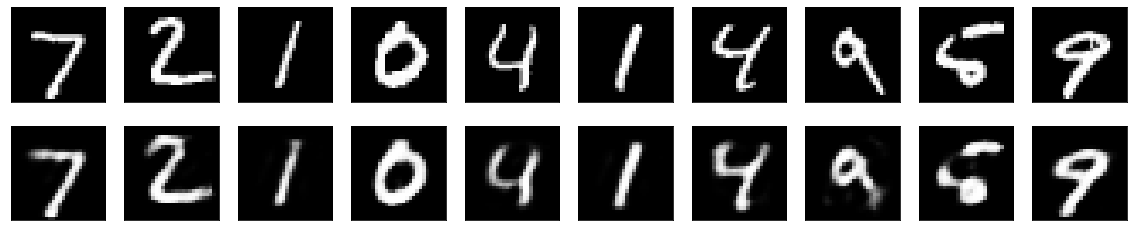

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
